344064/337723 [==============================] - 0s 0us/step


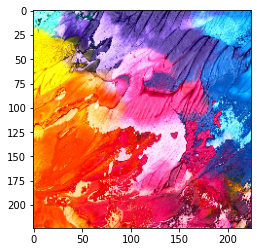

In [1]:
# 예제 8.42 : 원본 텍스처 이미지 불러오기
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

style_path = tf.keras.utils.get_file("style.jpg", 'http://bit.ly/2mGfZIq')

style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize = (224, 224))
style_image = style_image / 255.0
plt.imshow(style_image)

tf.Tensor([0.46539962 0.56712484 0.814811  ], shape=(3,), dtype=float32)


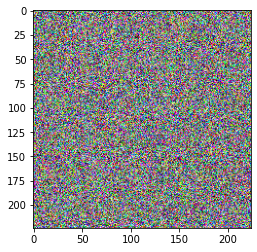

In [2]:
# 예제 8.43 : 타깃 텍스처 만들기
target_image = tf.random.uniform(style_image.shape)
print(target_image[0, 0, :])
plt.imshow(target_image)

In [3]:
# 예제 8.44 : VGG-19 네트워크 불러오기
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

vgg = VGG19(include_top = False, weights = 'imagenet')

for layer in vgg.layers:
  print(layer.name)

80142336/80134624 [==============================] - 1s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [0]:
# 예제 8.45 : 특징 추출 모델 만들기
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

vgg.trainable = False
outputs = [vgg.get_layer(name).output for name in style_layers]
model = tf.keras.Model([vgg.input], outputs)

In [0]:
# 예제 8.46 : Gram matrix 계산 함수 정의
def gram_matrix(input_tensor):
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a = True)
  
  return gram / tf.cast(n, tf.float32)

In [0]:
# 예제 8.47 : 원본 텍스처에서 Gram matrix 계산
style_image = plt.imread(style_path)
style_image = cv2.resize(style_image, dsize = (224, 224))
style_image = style_image / 255.0

style_batch = style_image.astype('float32')
style_batch = tf.expand_dims(style_batch, axis = 0)
style_output = model(preprocess_input(style_batch * 255.0))

(1, 224, 224, 64)


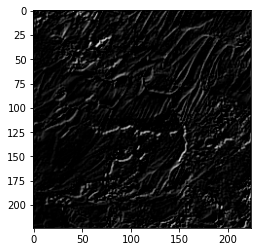

In [13]:
# 예제 8.48 : 원본 텍스처의 첫 번째 특징 추출값 확인
print(style_output[0].shape)
plt.imshow(tf.squeeze(style_output[0][:, :, :, 0], 0), cmap = 'gray')

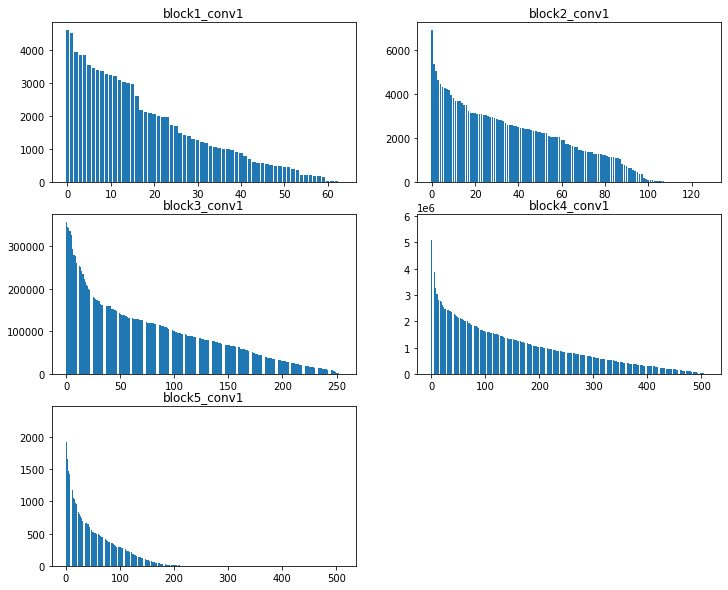

In [14]:
# 예제 8.49 : 원본 텍스처의 Gram matrix 계산값 만들기, 분포 확인
style_outputs = [gram_matrix(out) for out in style_output]

plt.figure(figsize = (12, 10))

for c in range(5):
  plt.subplot(3, 2, c + 1)
  array = sorted(style_outputs[c].numpy()[0].tolist())
  array = array[::-1]
  plt.bar(range(style_outputs[c].shape[0]), array)
  plt.title(style_layers[c])
plt.show()

In [0]:
# 예제 8.50 : 타깃 텍스처를 업데이트하기 위한 함수 정의
def get_outputs(image):
  image_batch = tf.expand_dims(image, axis = 0)
  output = model(preprocess_input(image_batch * 255.0))
  outputs = [gram_matrix(out) for out in output]

  return outputs

def get_loss(outputs, style_outputs):
  return tf.reduce_sum([tf.reduce_mean((o - s) ** 2) for o, s in zip(outputs, style_outputs)])

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)

In [0]:
# 에제 8.51 : tf.function과 GradientTape을 이용한 이미지 업데이트 함수 정의
opt = tf.optimizers.Adam(learning_rate = 0.2, beta_1 = 0.99, epsilon = 1e-1)

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = get_outputs(image)
    loss = get_loss(outputs, style_outputs)
  
  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

# @ 장식자

In [18]:
def verbose(fn):
  def wrapper():
    print('Start', fn.__name__)
    fn()
    print('End', fn.__name__)

  return wrapper

def hello_world():
  print('Hello, World!')

hello_world()

Hello, World!


In [19]:
hello_world = verbose(hello_world)
hello_world()

Start hello_world
Hello, World!
End hello_world


In [20]:
@verbose
def hello_world():
  print("Hello, World!")

hello_world()

Start hello_world
Hello, World!
End hello_world


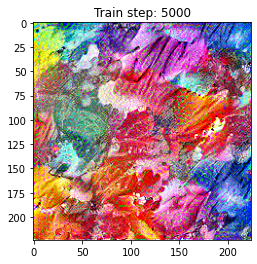

Total time: 122.0


In [28]:
# 예제 8.52 : 텍스처 합성 알고리즘 실행
import IPython.display as display
import time
import imageio

start = time.time()

image = tf.Variable(target_image)

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
  
  if n % 5 == 0 or n == epochs - 1:
    imageio.imwrite('style_epoch_{0}.png'.format(n), image.read_value().numpy())
  
  display.clear_output(wait = True)
  plt.imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end - start))

In [0]:
# 예제 8.53 : variation loss 함수 정의
def high_pass_x_y(image):
  x_var = image[:, 1:, :] - image[:, :-1, :]
  y_var = image[1:, :, :] - image[:-1, :, :]

  return x_var, y_var

def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_mean(x_deltas ** 2) + tf.reduce_mean(y_deltas ** 2)

In [30]:
# 예제 8.54 : variation loss 비교
print('target   :', total_variation_loss(image.read_value()))
print('noise    :', total_variation_loss(tf.random.uniform(style_image.shape)))
print('original :', total_variation_loss(style_image))

target   : tf.Tensor(0.104026526, shape=(), dtype=float32)
noise    : tf.Tensor(0.3335914, shape=(), dtype=float32)
original : tf.Tensor(0.03641251305469578, shape=(), dtype=float64)


In [0]:
# 예제 8.55 : variation loss를 손실 계산식에 추가, 각 손실의 가중치 추가
total_variation_weight = 1e9
style_weight = 1e-1

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = get_outputs(image)
    loss = style_weight * get_loss(outputs, style_outputs)
    loss += total_variation_weight * total_variation_loss(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

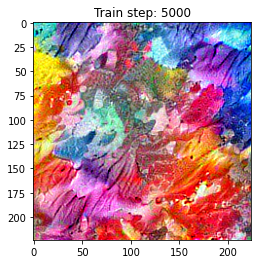

Total time: 122.5


In [32]:
# 예제 8.56 : variation loss를 추가한 텍스처 합성 알고리즘 실행
start = time.time()

target_image = tf.random.uniform(style_image.shape)
image = tf.Variable(target_image)

epochs = 50
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
  
  if n % 5 == 0 or n == epochs - 1:
    imageio.imwrite('style_variation_epoch_{0}.png'.format(n), image.read_value().numpy())
  
  display.clear_output(wait = True)
  plt.imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end - start))

In [33]:
# 예제 8.57 : 원본과 타깃의 variation loss 비교
print('target   :', total_variation_loss(image.read_value()))
print('original :', total_variation_loss(style_image))

target   : tf.Tensor(0.03255518, shape=(), dtype=float32)
original : tf.Tensor(0.03641251305469578, shape=(), dtype=float64)
